Будем решать задачу регрессии. Поработаем с данными о стоимости домов в Калифорнии. Задача — предсказать стоимость домов по различным числовым характеристикам:

*  MedInc — средний доход жителей. 
*  HouseAge — возраст дома.
*  AveRooms — среднее количество комнат в доме
и так далее.

Подробное описание признаков можно прочесть [в документации датасета](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

data = fetch_california_housing(as_frame=True)

In [2]:
X = data.data
y = data.target

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


В образовательных целях исследования и предобработки данных часто опускается этап изучения датасета на наличие дубликатов, пропусков, некорректных значений и так далее. Однако на практике при работе с данными до моделирования об этом не стоит забывать.

Например, рассмотрим датасет на наличие пропусков.

In [3]:
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Отлично, в данных нет пропущенных значений.

Перейдём к построению и оценке качества моделей.

Разобьём данные на train и test и обучим на них сначала решающее дерево с параметрами по умолчанию.

In [4]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

In [5]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor()

model_dt.fit(Xtrain, ytrain)

DecisionTreeRegressor()

Сделаем предсказание на тестовых данных и оценим ошибку MSE.

In [6]:
pred_dt = model_dt.predict(Xtest)

In [7]:
from sklearn.metrics import mean_squared_error

mean_squared_error(ytest, pred_dt)

0.5340007375545736

Теперь обучим на тренировочных данных случайный лес с параметрами по умолчанию.

In [8]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()

model_rf.fit(Xtrain, ytrain)

RandomForestRegressor()

Сделаем предсказание на тесте и оценим ошибку MSE.

In [11]:
pred_rf = model_rf.predict(Xtest)

mean_squared_error(ytest, pred_rf)

0.25943516657987675

Ошибка у леса в два раза меньше, чем у дерева!

Теперь изучим гиперпараметры леса.

In [ ]:
?RandomForestRegressor

In [13]:
import numpy as np

In [15]:
?np.sign

*   n_estimators — число деревьев;
*   criterion — критерий информативности для построения дерева;
*   max_depth — глубина деревьев в лесу;
*   min_samples_split — минимальное число объектов, необходимое для разбиения вершины;
*   min_samples_leaf — минимальное число объектов в вершине, для того чтобы она была листом;
*   max_features — максимальное число признаков, из которых ищем наилучшее разбиение на каждом шаге построения дерева;
*   max_samples — максимальное количество объектов в подвыборке, сформированной при помощи бутстрепа из исходной выборки.

Посмотрим, как меняется качество предсказания в зависимости от числа деревьев в лесу.

In [19]:
N = []
MSE = []

for n in np.arange(10, 120, 20):
    rf = RandomForestRegressor(n_estimators = n)

    rf.fit(Xtrain, ytrain)

    pred_rf = rf.predict(Xtest)

    N.append(n)
    MSE.append(mean_squared_error(ytest, pred_rf))

Text(0, 0.5, 'MSE on test')

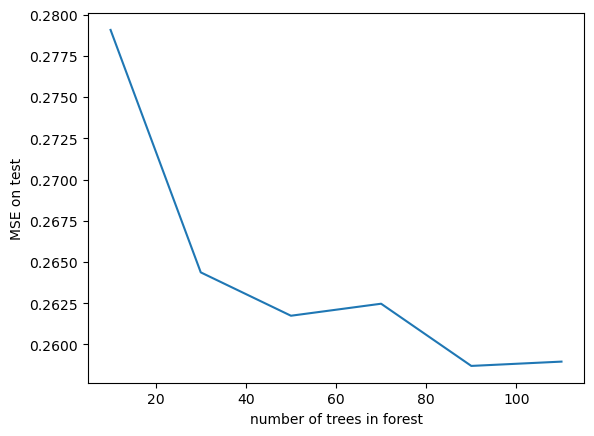

In [20]:
from matplotlib import pyplot as plt

plt.plot(N, MSE, '-')
plt.xlabel('number of trees in forest')
plt.ylabel('MSE on test')

Мы наблюдаем важную зависимость, и это неплохо запомнить: случайный лес не переобучается с увеличением числа деревьев!

То есть чем больше деревьев в лесу, тем меньше будет ошибка на тестовых данных. 

Однако начиная с какого-то числа деревьев ошибка уменьшается совсем незначительно, а при дальнейшем увеличении числа деревьев скорость обучения алгоритма падает.

Поэтому обычно выбирают минимальное число деревьев в лесу, при котором ошибка на тесте перестаёт сильно убывать.

Возьмём 100 деревьев в лесу, так как при 100 деревьях ошибка убывает уже несильно. Теперь будем перебирать глубину деревьев аналогичным образом.

In [21]:
D = []
MSE = []

for d in np.arange(2, 50, 5):
    rf = RandomForestRegressor(n_estimators = 100, max_depth = d)

    rf.fit(Xtrain, ytrain)

    pred_rf = rf.predict(Xtest)

    D.append(d)
    MSE.append(mean_squared_error(ytest, pred_rf))

Text(0, 0.5, 'MSE on test')

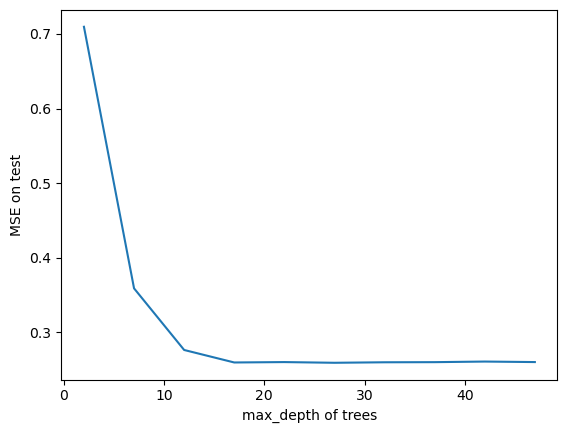

In [22]:
plt.plot(D, MSE, '-')
plt.xlabel('max_depth of trees')
plt.ylabel('MSE on test')

Мы видим, что сначала при увеличении глубины деревьев ошибка падает, а затем, примерно с глубины 20, ошибка начинает расти, то есть начинается переобучение.

Значит, для леса со 100 деревьями надо брать деревья максимальной глубины — 20.

Проверим, каких значений метрики удастся достичь при обучении случайного леса с найденными значениями гиперпараметров.

In [23]:
model_rf = RandomForestRegressor(n_estimators = 100, max_depth = 20)

model_rf.fit(Xtrain, ytrain)

pred_rf = model_rf.predict(Xtest)

mean_squared_error(ytest, pred_rf)

0.26109829756113356

С помощью подбора гиперпараметров удалось значительно снизить ошибку по сравнению с лесом, работающим с гиперпараметрами по умолчанию.

Другие гиперпараметры леса также важно подбирать, однако ручной перебор гиперпараметров сложен и может привести к переобучению. 

Давайте оценим качество последней модели по кросс-валидации, чтобы без привязки к разбиению на train-test оценить качество и переобучение модели.

In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RandomForestRegressor(n_estimators = 100, max_depth = 20), X, y, cv=3, scoring='neg_mean_squared_error')

In [25]:
scores

array([-0.51842335, -0.32825317, -0.55025576])

In [26]:
import numpy as np

np.mean(-scores)

0.4656440934453137

In [27]:
np.std(-scores)

0.09801538715051392

По стандартному отклонению метрики на кросс-валидации можно сказать, что наблюдается переобучение модели и нужно аккуратнее подбирать её гиперпараметры. Визуальный подбор может давать плохие результаты.

Как подбирать гиперпараметры моделей в полуавтоматическом режиме, вы узнаете в следующем видео.